In [1]:
%pip install scikitplot

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for scikitplot


In [1]:
%matplotlib inline
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
metrics, model_selection, pipeline, preprocessing, tree
#import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile
import xg_help as xhelp
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [2]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

c:\VSC\XGBoost\xg_help.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
c:\VSC\XGBoost\xg_help.py:102: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
c:\VSC\XGBoost\xg_help.py:103: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
c:\VSC\XGBoost\xg_help.py:104: FutureWarning: Downcasting behavior in `replace` 

In [3]:
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

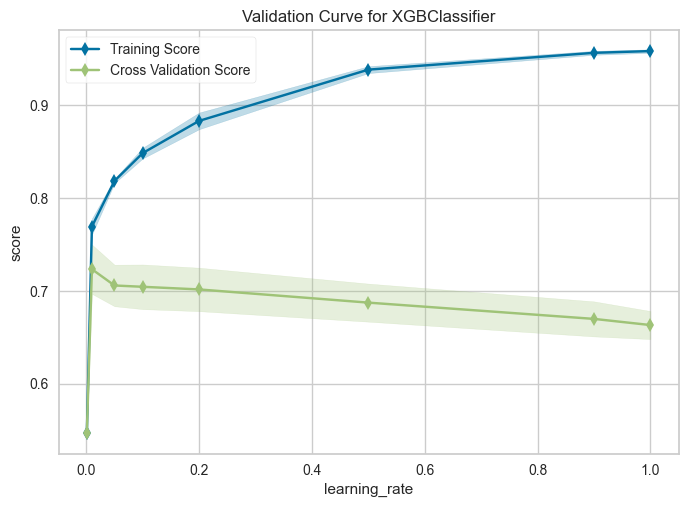

<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>

In [ ]:
from yellowbrick import model_selection as ms



viz = ms.ValidationCurve(
    xgb.XGBClassifier(), param_name='learning_rate',
    param_range=[0.001, .01, .05, .1, .2, .5, .9, 1],
    cv=5,scoring='accuracy'

)

viz.fit(X_train, y_train)
viz.show()



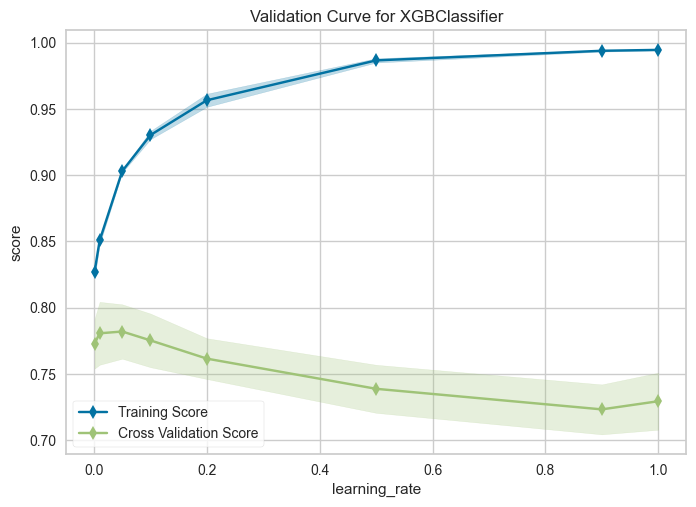

<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>

In [20]:
viz = ms.ValidationCurve(
    xgb.XGBClassifier(), param_name='learning_rate',
    param_range=[0.001, .01, .05, .1, .2, .5, .9, 1],
    cv=5,scoring='roc_auc'

)

viz.fit(X_train, y_train)
viz.show()

In [21]:
 from sklearn.metrics import roc_auc_score
 from hyperopt import hp, Trials, fmin, tpe

 params = {'random_state': 42}
 rounds = [{'max_depth': hp.quniform('max_depth', 1, 9, 1), # tree
 'min_child_weight': hp.loguniform('min_child_weight',-2, 3)},
 {'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
 'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
 {'gamma': hp.loguniform('gamma',-10, 10)}, # regularization
 {'learning_rate': hp.loguniform('learning_rate',-7, 0)} # boosting
 ]

 for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: xhelp.hyperparameter_tuning(
    space, X_train, y_train, X_test, y_test, metric=roc_auc_score),
    space=params,
    algo=tpe.suggest,
    max_evals=40,
    trials=trials,
    )
    
    params = {**params, **best}

100%|██████████| 40/40 [00:17<00:00,  2.22trial/s, best loss: -0.7672237162248688]


In [25]:
params = {'random_state': 42,
 'max_depth': np.int64(6.0),
 'min_child_weight': np.float64(0.1389021165909205),
 'subsample': np.float64(0.8435280005432383),
 'colsample_bytree': np.float64(0.9608538121984563),
 'gamma': np.float64(0.0007949608283476901),
 'learning_rate': np.float64(0.06250168441274392)}

In [27]:
xgb_tuned = xgb.XGBClassifier(**params, early_stopping_rounds=50, n_estimators=500)

xgb_tuned.fit(X_train, y_train, eval_set=[
                                (X_train,y_train),(X_test, y_test)], verbose=100)
 

[0]	validation_0-logloss:0.67037	validation_1-logloss:0.67202
[100]	validation_0-logloss:0.38365	validation_1-logloss:0.50232
[137]	validation_0-logloss:0.35092	validation_1-logloss:0.50883


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9608538121984563), device=None,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=np.float64(0.0007949608283476901), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.06250168441274392), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(6), max_leaves=None,
              min_child_weight=np.float64(0.1389021165909205), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [28]:
metrics.roc_auc_score(y_test, xgb_tuned.predict(X_test))

np.float64(0.7672237162248688)